In [143]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix


In [144]:
# leemos tablas
ipc_path = "~/Downloads/ipc.xlsx" # Modificar la ruta
market = pd.read_excel(ipc_path,index_col=0)
market.columns = [c.replace(" MF Equity", "").replace(" INDEX", "").replace("*", "") for c in market.columns]

emisoras_path = "~/Downloads/bmv_emisoras.csv"
emisoras = pd.read_csv(emisoras_path, index_col=0)


In [145]:
# homogeneizamos nombres de ambas tablas
in_emisoras = ['KIMBER','GAP','CEMEX','ASUR','GFNORTE','KOF','AC','LAB','FEMSA','OMA',
              'GFINBUR','AMX','ALSEA','ORBIA','PE&OLES','GRUMA','R','WALMEX','BOLSA','LIVEPOL','GENTERA','IENOVA',
               'CUERVO','ELEKTRA','BBAJIO','ALPEK','MEGA','GCC','BIMBO','GMEXICO','GCARSO','TLEVISA','ALFA',
               'BSMX','PINFRA','GBM']
in_market = ['KIMBERA','GAPB','CEMEXCPO','ASURB','GFNORTEO','KOFUBL','AC','LABB','FEMSAUBD','OMAB',
 'GFINBURO','AMXL','ALSEA','ORBIA','PE&OLES','GRUMAB','RA','WALMEX','BOLSAA','LIVEPOLC','GENTERA','IENOVA',
 'CUERVO','ELEKTRA','BBAJIOO','ALPEKA','MEGACPO','GCC','BIMBOA','GMEXICOB','GCARSOA1','TLEVICPO','ALFAA',
 'BSMXB','PINFRA','MEXBOL']
i = 0

for emisora in in_emisoras:
    as_list = emisoras.index.tolist()
    idx = as_list.index(emisora)
    as_list[idx] = in_market[i]
    emisoras.index = as_list
    i += 1


In [146]:
#emisoras.head()

In [147]:
catalog = pd.DataFrame(market.columns.tolist(),columns=['key']).join(emisoras,on="key")[['key','Sector']].set_index('key')
columns = zip(catalog.Sector,catalog.index)
market.columns = pd.MultiIndex.from_tuples(columns, names = ['sector', 'emisora'])
market.head(2)

sector     PRODUCTOS DE CONSUMO FRECUENTE INDUSTRIAL MATERIALES INDUSTRIAL  \
emisora                           KIMBERA       GAPB   CEMEXCPO      ASURB   
DATE                                                                         
2016-01-01                          40.37     152.05       8.72     243.89   
2016-01-04                          39.16     148.57       8.43     238.29   

sector     SERVICIOS FINANCIEROS PRODUCTOS DE CONSUMO FRECUENTE          \
emisora                 GFNORTEO                         KOFUBL      AC   
DATE                                                                      
2016-01-01                 94.99                         123.90  104.68   
2016-01-04                 91.79                         120.29  102.09   

sector      SALUD PRODUCTOS DE CONSUMO FRECUENTE INDUSTRIAL  ...  \
emisora      LABB                       FEMSAUBD       OMAB  ...   
DATE                                                         ...   
2016-01-01  13.85                         161.63      83.61  ...   
2016-01-04  14.41                         157.62      81.77  ...   

sector     SERVICIOS DE TELECOMUNICACIONES MATERIALES  \
emisora                            MEGACPO        GCC   
DATE                                                    
2016-01-01                           64.19      44.81   
2016-01-04                           64.45      43.51   

sector     PRODUCTOS DE CONSUMO FRECUENTE MATERIALES INDUSTRIAL  \
emisora                            BIMBOA   GMEXICOB   GCARSOA1   
DATE                                                              
2016-01-01                          45.95      36.79      70.98   
2016-01-04                          45.02      35.71      69.83   

sector     SERVICIOS DE TELECOMUNICACIONES INDUSTRIAL SERVICIOS FINANCIEROS  \
emisora                           TLEVICPO      ALFAA                 BSMXB   
DATE                                                                          
2016-01-01                           94.34      34.10                 30.25   
2016-01-04                           92.62      33.74                 29.46   

sector     INDUSTRIAL SERVICIOS FINANCIEROS  
emisora        PINFRA                MEXBOL  
DATE                                         
2016-01-01     202.73               42977.5  
2016-01-04     202.93               42113.7  

[2 rows x 36 columns]

In [148]:
y = (market[("SERVICIOS FINANCIEROS","MEXBOL")].diff().shift(-1) > 0) * 1.0
y.name = 'MEXBOL'

X = market.drop(("SERVICIOS FINANCIEROS","MEXBOL"), axis=1)
# nos quedamos con la info por sector para agrupar
X.columns = X.columns.droplevel(1)
X = X.T.groupby('sector').mean().T # pasamos de las 35 columnas a 8 agrupadas por sector
X = X.join(y, how="inner")


y = X["MEXBOL"]
X = X.drop("MEXBOL", axis=1)


In [149]:
train_period = "2019-10"
test_period = "2019-11-20"
Xtrain, ytrain = X[:train_period], y[:train_period]
Xtest, ytest = X[:test_period], y[:test_period]


In [185]:
from sklearn.model_selection import GridSearchCV


pipe = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("lor",LogisticRegression(penalty = 'l2'))
])

params = {
    "lor__C": np.logspace(-4, 4, 50),
    #'penalty': ['l1','l2']
    'lor__max_iter' : [3000],
    
}
# Inicializando el modelo
gcv = GridSearchCV(pipe, params, scoring="accuracy", n_jobs=-1)



In [186]:
gcv.fit(Xtrain, ytrain)

/Users/grguevara/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/grguevara/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('lor',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                    

In [187]:
res = cross_validate(gcv, Xtrain, ytrain, scoring="accuracy")
res['test_score']

/Users/grguevara/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/grguevara/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/grguevara/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/grguevara/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.war

array([0.47305389, 0.43113772, 0.48192771])

In [188]:
yhat = gcv.predict(Xtest)

In [189]:
confusion_matrix(ytest, yhat, labels=[0, 1])


array([[337, 182],
       [193, 302]])

In [195]:
precision_score(ytest, yhat)

0.6239669421487604

In [196]:
recall_score(ytest, yhat)

0.6101010101010101

In [197]:
f1, f1_score(ytest, yhat)

(0.6206896551724138, 0.6169560776302349)

Text(0.5, 0, 'Nivel de proba asignada')

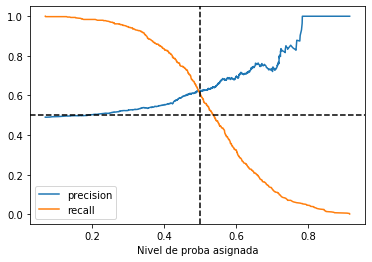

In [193]:

proba_estimate = gcv.predict_proba(Xtest)[:, 1]
precision, recall, threshold = precision_recall_curve(ytest, proba_estimate)

plt.plot(threshold, precision[:-1], label="precision")
plt.plot(threshold, recall[:-1], label="recall")
plt.legend()
plt.axvline(x=0.5, linestyle="--", c="black")
plt.axhline(y=0.5, linestyle="--", c="black")
plt.xlabel("Nivel de proba asignada")